In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import os
import time
import math

In [3]:
#activity labels as defined in activity_labels.txt
activity_labels = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS', 'SITTING', 'STANDING', 'LAYING', 'STAND_TO_SIT', 'SIT_TO_STAND', 'SIT_TO_LIE', 'LIE_TO_SIT', 'STAND_TO_LIE', 'LIE_TO_STAND']
#activity_labels = {k:v for k,v in enumerate(activity_labels, start=1)}
#print(activity_labels)

In [4]:
#load data
def load_data(path):
    data = pd.read_csv(path, header=None, delim_whitespace=True)
    return data.values

def load_set(path, x, y):
    data = load_data(path+x)
    labels = load_data(path+y)
    return data, labels

#reduce the labels by 1 to match with the activity_labels and also to start labels at 0 to 11 instead of from 1 to 12
def adjust_labels (labels):
    for i in range(len(labels)-1):
        labels[i][0] -= 1
    return labels

train_data, train_labels = load_set('HAPT Data Set/Train/', 'X_train.txt', 'y_train.txt')
test_data, test_labels = load_set('HAPT Data Set/Test/', 'X_test.txt', 'y_test.txt')

print('reshaping data...')
#reshape the data to add a features dimension (features = 1)
#https://stackoverflow.com/questions/43396572/dimension-of-shape-in-conv1d
train_data = np.expand_dims(train_data, axis=2)
test_data = np.expand_dims(test_data, axis=2)

print('adjusting labels...')
train_labels = adjust_labels(train_labels);
test_labels = adjust_labels(test_labels);

reshaping data...
adjusting labels...


In [5]:
#get time of epochs to record training time
#https://stackoverflow.com/questions/43178668/record-the-computation-time-for-each-epoch-in-keras-during-model-fit
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [6]:
#print out n number (pred_range) of predicted values and compare them with test labels
def predict(pred_range, pred_outs, test_labels):
    #test if the label matches the prediction
    false_pred = 0
    true_pred = 0
    #look at predictions for the first 25 values
    for i in range(pred_range):
        if not (0 <= pred_outs[i] or pred_outs[i] <= 11):
            print('prediction out of bounds')
            break

        print(f'Test label: {activity_labels[test_labels[i][0]]}')
        print(f'Predicted label:{activity_labels[pred_outs[i]]}')

        if pred_outs[i]==test_labels[i][0]:
            print('true\n')
            true_pred += 1
        else:
            print('false\n')
            false_pred += 1
    print(f'False predictions:{false_pred}')
    print(f'True predictions:{true_pred}')
    print(f'Prediction accuraccy for first 25 values: {true_pred/pred_range}')

In [21]:
def run_model(test_data, test_labels, train_data, train_labels, filters, kernel_size, dropout, epochs, it='', predict=True):
    save_path = f'filters-{filters}_kernel_size-{kernel_size}_dropout-{dropout}_epochs-{epochs}_it-{it}'
    saved_model_path = f'saved_models\\{save_path}'
    current_directory = os.path.abspath(os.getcwd())
    training_time=-1   #denotes pre-trained model being loaded froms saved data
    
    if os.path.exists(os.path.join(current_directory,saved_model_path)) :
        print(f'found saved model, loading from: {saved_model_path}')
        model = models.load_model(saved_model_path)
        test_loss,test_acc = model.evaluate( test_data, test_labels, verbose=2)
    else:
        #input shape
        timesteps = train_data.shape[1] #561 timesteps
        features = train_data.shape[2] #1 feature

        #model
        model = models.Sequential()
        model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, activation='relu', input_shape=(timesteps,features)))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Conv1D(filters=filters, kernel_size=kernel_size, strides=1, activation='relu'))
        model.add(layers.MaxPooling1D(pool_size=2))
        model.add(layers.Dropout(dropout))
        model.add(layers.Flatten())
        model.add(layers.Dense(64, activation='relu'))
        model.add(layers.Dense(32, activation='relu'))
        model.add(layers.Dense(12, activation='relu'))
        model.summary()

        # Compile the model
        model.compile(optimizer='adam',
                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                 metrics=['accuracy'])
        #evaluate model
        test_loss,test_acc = model.evaluate(test_data, test_labels, verbose=2)

        if predict:
            #predict
            pred_outs = model.predict_classes(test_data)
            #display predictions
            predict(10, pred_outs, test_labels)

        #train the model
        #set up timing callback
        time_callback = TimeHistory()

        model.fit(train_data, 
                  train_labels, 
                  epochs=epochs, 
                  validation_data=(test_data, test_labels),
                callbacks=[time_callback])

        test_loss,test_acc = model.evaluate( test_data, test_labels, verbose=2)

        training_time = sum(time_callback.times)

        model.save(saved_model_path)
    
    return test_loss, test_acc, training_time

In [22]:
def time_unit_string(time):
    return f"Total training time: {math.floor(time/1)}s {math.floor(time%1 * 1000)}ms {math.ceil(time%(1/1000)*1000)}us"

class RunTests: 
    n_tests = 10
    d_epochs = 10
    d_filters = 64
    d_kernel_size=3
    d_dropout=0.5
    
    def test_param(self, filters=d_filters, kernel_size=d_kernel_size, dropout=d_dropout, epochs=d_epochs):
        if isinstance(filters,list):
            data = filters
            data_type = 'filters'
        elif isinstance(kernel_size,list):
            data = kernel_size
            data_type = 'kernel_size'
        elif isinstance(dropout,list):
            data = dropout
            data_type = 'dropout'
        elif isinstance(epochs,list):
            data = epochs
            data_type = 'epochs'
        else:
            print('no data type selected, running default...')
            data = [1]
            data_type = 'default'
        
        model_test_data = []
        for index, item in enumerate(data):
            model_test_data.append([])
            for i in range(0,self.n_tests):
                if data_type == 'filters':
                    loss, acc, time = run_model(test_data, test_labels, train_data, train_labels, predict=False,
                                                kernel_size=kernel_size, 
                                                filters=item, 
                                                dropout=dropout,
                                                epochs=epochs,
                                                it=i)
                elif data_type == 'kernel_size':
                    loss, acc, time = run_model(test_data, test_labels, train_data, train_labels, predict=False,
                                                kernel_size=item, 
                                                filters=filters, 
                                                dropout=dropout,  
                                                epochs=epochs,
                                                it=i)
                elif data_type == 'dropout':
                    loss, acc, time = run_model(test_data, test_labels, train_data, train_labels, predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=item,  
                                                epochs=epochs,
                                                it=i)
                elif data_type == 'epochs':
                    loss, acc, time = run_model(test_data, test_labels, train_data, train_labels, predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=dropout,  
                                                epochs=item,
                                                it=i)
                else:
                    loss, acc, time = run_model(test_data, test_labels, train_data, train_labels, predict=False,
                                                kernel_size=kernel_size, 
                                                filters=filters, 
                                                dropout=dropout,  
                                                epochs=epochs,
                                                it=i)
                test_output = {'loss': loss, 'acc': acc, 'time': time, 'test parameter': item}
                model_test_data[index].append(test_output)
        return model_test_data

    #data is a two-dimensional list
    def print_results(self,data, data_name):
        print(f"{data_name} test data:")
        for test in data:
            for i in range(0,self.n_tests):
                print(f"{data_name}: {test[i].get('test parameter')}")
                print(f"\tloss: {test[i].get('loss')}")
                print(f"\taccuracy: {test[i].get('acc')}")
            print("\n")
    
    def plot_results(self, data, data_name):
        loss=[]
        acc=[]
        param=[]
        for index, test in enumerate(data):
            param.append(test[0].get('test parameter'))
            loss.append([])
            acc.append([])
            for i in range(0,self.n_tests):
                loss[index].append(test[i].get('loss'))
                acc[index].append(test[i].get('acc'))
        
        fig, axs = plt.subplots(2)
        axs[0].set_title(f'{data_name} loss')
        axs[0].set(xlabel=data_name, ylabel='Loss')
        axs[0].boxplot(loss)
        axs[0].set_xticklabels(param)
        
        axs[1].set_title(f'{data_name} accuracy')
        axs[1].set(xlabel=data_name, ylabel='Accuracy')
        axs[1].boxplot(acc)
        axs[1].set_xticklabels(param)
        
        fig.subplots_adjust(hspace=0.8)
        
        plt.show
        
runner = RunTests() 

In [23]:
filters_data = runner.test_param(filters=[32, 64, 128])

found saved model, loading from: saved_models\filters-32_kernel_size-3_dropout-0.5_epochs-10_it-0
3162/3162 - 0s - loss: 0.2155 - accuracy: 0.9244
found saved model, loading from: saved_models\filters-32_kernel_size-3_dropout-0.5_epochs-10_it-1
3162/3162 - 0s - loss: 0.3336 - accuracy: 0.8861
found saved model, loading from: saved_models\filters-32_kernel_size-3_dropout-0.5_epochs-10_it-2
3162/3162 - 0s - loss: 1.0572 - accuracy: 0.5765
found saved model, loading from: saved_models\filters-32_kernel_size-3_dropout-0.5_epochs-10_it-3
3162/3162 - 0s - loss: 0.6840 - accuracy: 0.7495
found saved model, loading from: saved_models\filters-32_kernel_size-3_dropout-0.5_epochs-10_it-4
3162/3162 - 0s - loss: 1.0180 - accuracy: 0.6078
found saved model, loading from: saved_models\filters-32_kernel_size-3_dropout-0.5_epochs-10_it-5
3162/3162 - 0s - loss: 0.6288 - accuracy: 0.7846
found saved model, loading from: saved_models\filters-32_kernel_size-3_dropout-0.5_epochs-10_it-6
3162/3162 - 0s - los

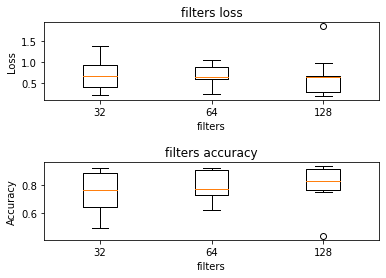

In [43]:
#runner.print_results(filters_data, 'filters')
runner.plot_results(filters_data, 'filters')
plt.savefig("plots/filters-32-64-128.png")

In [25]:
dropout_data = runner.test_param(dropout = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])

found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0_epochs-10_it-0
3162/3162 - 1s - loss: 0.3003 - accuracy: 0.9010
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0_epochs-10_it-1
3162/3162 - 1s - loss: 0.6750 - accuracy: 0.7634
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0_epochs-10_it-2
3162/3162 - 1s - loss: 0.7303 - accuracy: 0.7375
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0_epochs-10_it-3
3162/3162 - 1s - loss: 0.7088 - accuracy: 0.7641
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0_epochs-10_it-4
3162/3162 - 1s - loss: 0.2099 - accuracy: 0.9355
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0_epochs-10_it-5
3162/3162 - 1s - loss: 0.6161 - accuracy: 0.9263
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0_epochs-10_it-6
3162/3162 - 1s - loss: 0.6994 - ac

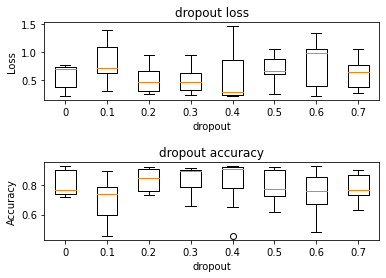

In [44]:
#runner.print_results(dropout_data, 'dropout')
runner.plot_results(dropout_data, 'dropout')
plt.savefig("plots/dropout-0-to-0.7.png")

In [27]:
kernel_size_data = runner.test_param(kernel_size = [2,3,5,7,9,11])

Model: "sequential_69"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_138 (Conv1D)          (None, 560, 64)           192       
_________________________________________________________________
max_pooling1d_138 (MaxPoolin (None, 280, 64)           0         
_________________________________________________________________
conv1d_139 (Conv1D)          (None, 279, 64)           8256      
_________________________________________________________________
max_pooling1d_139 (MaxPoolin (None, 139, 64)           0         
_________________________________________________________________
dropout_69 (Dropout)         (None, 139, 64)           0         
_________________________________________________________________
flatten_69 (Flatten)         (None, 8896)              0         
_________________________________________________________________
dense_207 (Dense)            (None, 64)              

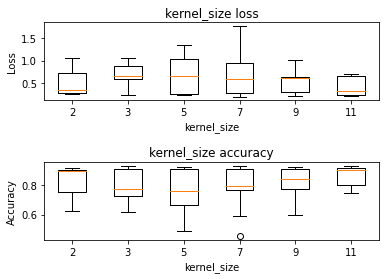

In [45]:
#runner.print_results(kernel_size_data, 'kernel_size')
runner.plot_results(kernel_size_data, 'kernel_size')
plt.savefig("plots/kernel-size-2-3-5-7-9-11.png")

In [29]:
default_data = runner.test_param()

no data type selected, running default...
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-10_it-0
3162/3162 - 1s - loss: 0.6135 - accuracy: 0.9247
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-10_it-1
3162/3162 - 1s - loss: 0.5921 - accuracy: 0.7875
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-10_it-2
3162/3162 - 1s - loss: 0.2480 - accuracy: 0.9187
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-10_it-3
3162/3162 - 1s - loss: 0.9100 - accuracy: 0.6610
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-10_it-4
3162/3162 - 1s - loss: 0.6608 - accuracy: 0.8877
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-10_it-5
3162/3162 - 1s - loss: 0.7964 - accuracy: 0.7239
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropo

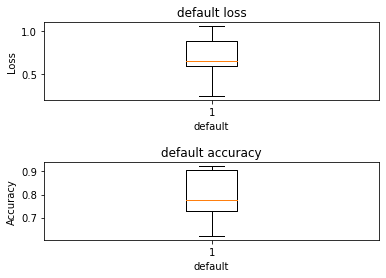

In [46]:
runner.plot_results(default_data, 'default')
plt.savefig("plots/default-f64-ks3-do0.5-epch10.png")

In [32]:
epoch_data = runner.test_param(epochs=[5,10,15,20])

found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-5_it-0
3162/3162 - 1s - loss: 0.7084 - accuracy: 0.7489
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-5_it-1
3162/3162 - 1s - loss: 0.3023 - accuracy: 0.8877
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-5_it-2
3162/3162 - 1s - loss: 0.6280 - accuracy: 0.8997
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-5_it-3
3162/3162 - 1s - loss: 1.0441 - accuracy: 0.6306
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-5_it-4
3162/3162 - 1s - loss: 0.3040 - accuracy: 0.8830
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-5_it-5
3162/3162 - 1s - loss: 0.2685 - accuracy: 0.9061
found saved model, loading from: saved_models\filters-64_kernel_size-3_dropout-0.5_epochs-5_it-6
3162/3162 - 1s - loss: 0.63

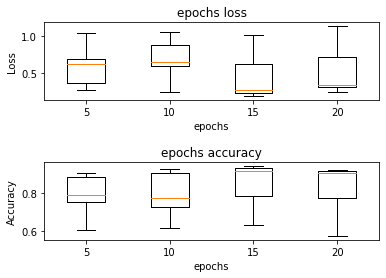

In [47]:
runner.plot_results(epoch_data, 'epochs')
plt.savefig('plots/epoch-5-10-15-20.png')